In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from mykaggle.metric.mse import rmsle
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.lib.pandas_util import change_column_name
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
settings = yaml.safe_load('''
name: '005_eda'
competition: atmacup8
seed: 1019
training:
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: binary
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 17), (8360, 12))

In [6]:
df_train.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [7]:
df_test.head().T

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4
Name,Hitman 2: Silent Assassin,Legacy of Kain: Soul Reaver,Metal Gear Solid 2: Substance,Silent Hill: Homecoming,Silent Hill: Homecoming
Platform,XB,PS,XB,X360,PS3
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Eidos Interactive,Eidos Interactive,Konami Digital Entertainment,Konami Digital Entertainment,Konami Digital Entertainment
Critic_Score,84,91,87,70,71
Critic_Count,23,17,28,54,41
User_Score,8,9,8.5,6.9,6.9
User_Count,19,132,39,180,143
Developer,Io Interactive,Crystal Dynamics,KCEJ,Double Helix Games,Double Helix Games


In [8]:
df_submission.head()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Global_Sales
0,63.371815
1,63.371815
2,63.371815
3,63.371815
4,63.371815


# train

In [9]:
len(list(df_train.columns)), list(df_train.columns)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(17,
 ['Name',
  'Platform',
  'Year_of_Release',
  'Genre',
  'Publisher',
  'NA_Sales',
  'EU_Sales',
  'JP_Sales',
  'Other_Sales',
  'Global_Sales',
  'Critic_Score',
  'Critic_Count',
  'User_Score',
  'User_Count',
  'Developer',
  'Rating',
  'id'])

# train/test 

In [10]:
train = df_train.copy()
test = df_test.copy()

train.loc[:, 'is_test'] = False
test.loc[:, 'is_test'] = True
whole = pd.concat([train, test])
whole.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id,is_test
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180.0,97.0,0.0,28.0,306.0,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0,False
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151.0,61.0,0.0,21.0,234.0,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,1,False
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56.0,44.0,0.0,27.0,128.0,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,2,False
3,Combat,2600,NaN,Action,Atari,117.0,7.0,0.0,1.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,3,False
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69.0,42.0,0.0,12.0,124.0,76.0,8.0,7.8,13.0,Traveller's Tales,E10+,4,False


In [11]:
df_base_train = df_train.loc[:, ['id']]
df_base_test = df_test.loc[:, ['id']]

train_others = {
    'main': df_train.copy(),
    'another': df_test.copy()
}
test_others = {
    'main': df_test.copy(),
    'another': df_train.copy(),
}

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## categry を見る

In [12]:
def countplot(df: pd.DataFrame, column: str) -> None:
    print(f'{column}: {df.loc[:, column].unique()}')
    plt.figure(figsize=(20, 8))
    sns.countplot(data=df, x=column, hue='is_test')
    plt.title(column)
    plt.tight_layout()

Year_of_Release: [  nan 1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990.
 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002.
 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014.
 2015. 2016. 2017. 2020.]


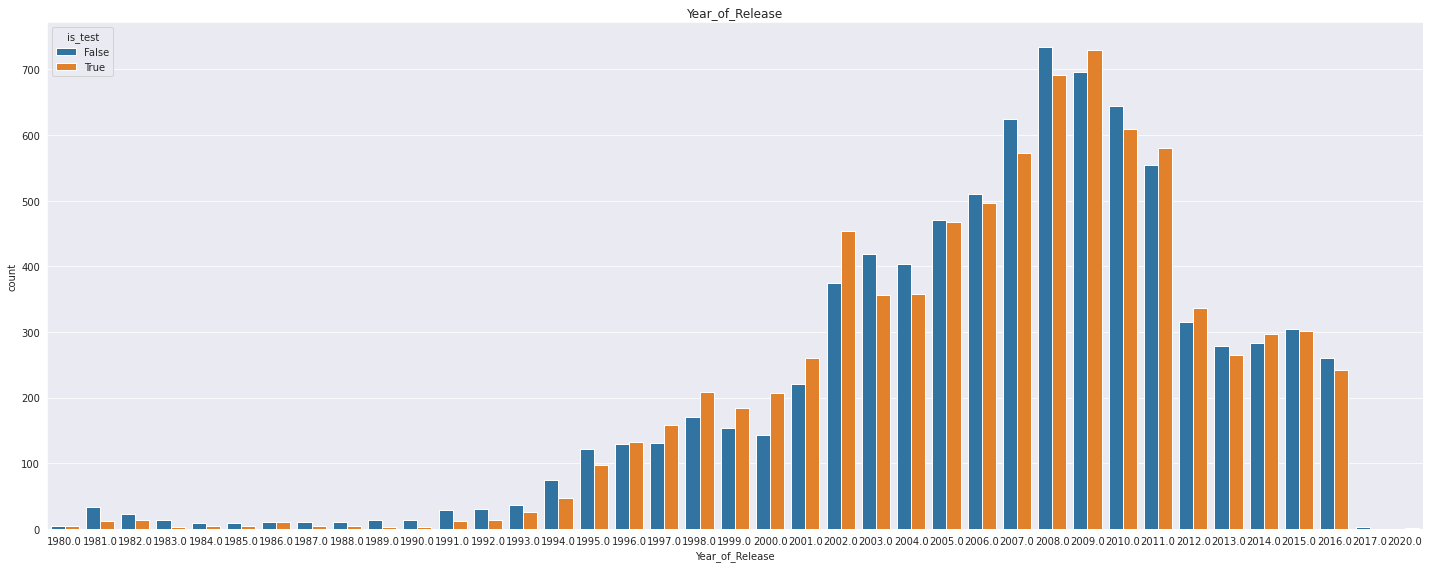

In [13]:
countplot(whole, 'Year_of_Release')

In [14]:
np.sum(whole['Year_of_Release'].isna())

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


269

# Name をみる

In [15]:
whole.loc[:, ['Name']].value_counts()

Name                                  
Need for Speed: Most Wanted               12
Madden NFL 07                              9
LEGO Marvel Super Heroes                   9
Ratatouille                                9
FIFA 14                                    9
                                          ..
Paws & Claws: Pampered Pets 2              1
Paws & Claws: Pampered Pets                1
Paws & Claws: Marine Rescue                1
Paws & Claws: Dogs & Cats Best Friends     1
 Beyblade Burst                            1
Length: 11562, dtype: int64

In [16]:
whole[whole['Name'] == 'LEGO Marvel Super Heroes']

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id,is_test
7237,LEGO Marvel Super Heroes,X360,2013.0,Action,Warner Bros. Interactive Entertainment,124.0,79.0,0.0,19.0,222.0,80.0,37.0,7.6,127.0,TT Games,E10+,7237,False
7240,LEGO Marvel Super Heroes,PS3,2013.0,Action,Warner Bros. Interactive Entertainment,77.0,76.0,1.0,28.0,184.0,82.0,22.0,7.9,76.0,TT Games,E10+,7240,False
7242,LEGO Marvel Super Heroes,PS4,2013.0,Action,Warner Bros. Interactive Entertainment,59.0,76.0,1.0,26.0,162.0,83.0,22.0,7.7,262.0,TT Games,E10+,7242,False
7247,LEGO Marvel Super Heroes,XOne,2013.0,Action,Warner Bros. Interactive Entertainment,61.0,35.0,0.0,9.0,106.0,NaN,NaN,6.8,73.0,TT Games,E10+,7247,False
7249,LEGO Marvel Super Heroes,3DS,2013.0,Action,Warner Bros. Interactive Entertainment,42.0,36.0,4.0,7.0,90.0,61.0,4.0,5.2,11.0,TT Games,E10+,7249,False
7252,LEGO Marvel Super Heroes,WiiU,2013.0,Action,Warner Bros. Interactive Entertainment,31.0,35.0,2.0,6.0,74.0,82.0,8.0,8,71.0,TT Games,E10+,7252,False
7256,LEGO Marvel Super Heroes,PSV,2013.0,Action,Warner Bros. Interactive Entertainment,11.0,28.0,0.0,11.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,7256,False
7261,LEGO Marvel Super Heroes,DS,2013.0,Action,Warner Bros. Interactive Entertainment,22.0,13.0,0.0,3.0,38.0,NaN,NaN,4.8,5.0,TT Games,E10+,7261,False
7276,LEGO Marvel Super Heroes,PC,2013.0,Action,Warner Bros. Interactive Entertainment,4.0,12.0,0.0,1.0,17.0,78.0,7.0,8.1,124.0,TT Games,E10+,7276,False


In [17]:
le = LabelEncoder()
le.fit(whole['Platform'])
whole['le_Platform'] = le.transform(whole['Platform'])
platform_list = whole.groupby('Name')['le_Platform'].apply(list).reset_index()
platform_list = change_column_name(platform_list, 'le_Platform', 'other_platforms')
platform_list

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,other_platforms
0,Beyblade Burst,[2]
1,Fire Emblem Fates,[2]
2,Frozen: Olaf's Quest,"[2, 4]"
3,Haikyu!! Cross Team Match!,[2]
4,Tales of Xillia 2,[17]
...,...,...
11557,thinkSMART: Chess for Kids,[4]
11558,uDraw Studio,[26]
11559,uDraw Studio: Instant Artist,"[26, 28]"
11560,wwe Smackdown vs. Raw 2006,[16]


In [18]:
def get_other_platforms(x):
    if np.isnan(x['other_platforms']).any():
        return []
    return [p for p in x['other_platforms'] if p != x['le_Platform']]

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
merge = pd.merge(whole, platform_list, how='left', on='Name')
merge['other_platforms'] = merge[['other_platforms', 'le_Platform']].apply(get_other_platforms, axis=1)
merge.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id,is_test,le_Platform,other_platforms
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180.0,97.0,0.0,28.0,306.0,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0,False,26,"[19, 28, 4, 17, 16, 13]"
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151.0,61.0,0.0,21.0,234.0,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,1,False,26,"[16, 19, 13, 28, 4, 17]"
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56.0,44.0,0.0,27.0,128.0,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,2,False,19,"[26, 28, 4, 17, 16, 13]"
3,Combat,2600,NaN,Action,Atari,117.0,7.0,0.0,1.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,3,False,0,[]
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69.0,42.0,0.0,12.0,124.0,76.0,8.0,7.8,13.0,Traveller's Tales,E10+,4,False,26,"[28, 17, 4, 2, 19, 13, 20]"


In [20]:
num_platforms = len(merge['le_Platform'].unique())
onehot = np.zeros((merge.shape[0], num_platforms), dtype=np.int32)
for i, other_platforms in enumerate(merge['other_platforms']):
    for p in other_platforms:
        onehot[i, p] = 1

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
df_onehot = pd.DataFrame(onehot, columns=[f'other_platform_{i+1}'for i in range(onehot.shape[1])])
merge = pd.concat([merge, df_onehot], axis=1)
merge.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,other_platform_22,other_platform_23,other_platform_24,other_platform_25,other_platform_26,other_platform_27,other_platform_28,other_platform_29,other_platform_30,other_platform_31
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180.0,97.0,0.0,28.0,306.0,...,0,0,0,0,0,0,0,1,0,0
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151.0,61.0,0.0,21.0,234.0,...,0,0,0,0,0,0,0,1,0,0
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56.0,44.0,0.0,27.0,128.0,...,0,0,0,0,0,1,0,1,0,0
3,Combat,2600,NaN,Action,Atari,117.0,7.0,0.0,1.0,125.0,...,0,0,0,0,0,0,0,0,0,0
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69.0,42.0,0.0,12.0,124.0,...,0,0,0,0,0,0,0,1,0,0


In [22]:
from mykaggle.feature.other_platforms import OtherPlatforms
other_platforms = OtherPlatforms(train=True)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
other_platforms(df_train.copy(), train_others)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,other_platform_22,other_platform_23,other_platform_24,other_platform_25,other_platform_26,other_platform_27,other_platform_28,other_platform_29,other_platform_30,other_platform_31
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,...,0,0,0,0,0,0,0,1,0,0
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,...,0,0,0,0,0,0,0,1,0,0
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,...,0,0,0,0,0,1,0,1,0,0
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,...,0,0,0,0,0,0,0,0,0,0
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,0,4,0,0,4,...,0,0,0,0,0,0,0,0,0,0
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0,0,4,0,4,...,0,0,0,0,0,0,0,0,0,0


Name がかぶってるやつは複数 Platform で出てるやつ?

1個じゃないやつは割とある (全体の半分)

In [ ]:
print('whole, eq 1, lt 1')
print(np.sum(whole.loc[:, ['Name']].value_counts() == 1), ',', np.sum(whole.loc[:, ['Name']].value_counts() != 1))
print('train test lt 1')
print(np.sum(train.loc[:, ['Name']].value_counts() != 1), np.sum(test.loc[:, ['Name']].value_counts() != 1))

In [ ]:
multi_platform = (train.loc[:, ['Name']].value_counts()).reset_index()
multi_platform = change_column_name(multi_platform, 0, 'multi_pf_count')
multi_platform['is_multi_platform'] = multi_platform.loc[:, 'multi_pf_count'] >= 1
multi_platform.head()

In [ ]:
train.loc[train.loc[:, ['Name']].value_counts() != 1, 'Name']

Name 被ってて train/test に別れてる (=Publisher が別)があるけどなんだ?

In [ ]:
name_duplicated = whole.groupby('Name')['is_test'].mean().reset_index()
name_duplicated.head()

In [ ]:
name_duplicated['is_not_1'] = name_duplicated['is_test'] != 1.0
name_duplicated['is_not_0'] = name_duplicated['is_test'] != 0.0
name_duplicated['is_not_01'] = name_duplicated['is_not_1'] * name_duplicated['is_not_0']
name_duplicated.shape

In [ ]:
name_duplicated[name_duplicated['is_not_01']]

In [ ]:
whole.loc[whole['Name'] == '428: Fuusa Sareta Shibuya de']

1つのソフトでPublisher はまたがることがある

# Score, Count をみる

In [ ]:
train = df_train.copy()
test = df_test.copy()

train.loc[:, 'is_test'] = False
test.loc[:, 'is_test'] = True
whole = pd.concat([train, test])

In [ ]:
train.loc[:, 'User_Count']

In [ ]:
train.loc[:, 'User_Score'] / 10.0

In [ ]:
# nan の割合
print('User_Score train:', train[train['User_Score'].isna()].shape[0], train[train['User_Score'].isna()].shape[0] / train.shape[0])
print('User_Score test:', test[test['User_Score'].isna()].shape[0], test[test['User_Score'].isna()].shape[0] / test.shape[0])
print('Critic_Score train:', train[train['Critic_Score'].isna()].shape[0], train[train['Critic_Score'].isna()].shape[0] / train.shape[0])
print('Critic_Score test:', test[test['Critic_Score'].isna()].shape[0], test[test['Critic_Score'].isna()].shape[0] / test.shape[0])

In [ ]:
# 数字でも NaN でもないやつある? -> ある。tbd が 1132 個
train[~train['User_Score'].isna() & train['User_Score'].str.isalpha()]['User_Score'].value_counts()

In [ ]:
# train[~train['Critic_Score'].isna() & train['Critic_Score'].str.isalpha()]['Critic_Score'].value_counts()
# Critic_Score にはない

In [ ]:
# tbd をみる。User_Count は nan になる
train[~train['User_Score'].isna() & train['User_Score'].str.isalpha()].head()

In [ ]:
# tbd と nan 何が違う?
train[train['User_Score'].isna()]

In [ ]:
train.loc[train['User_Score'] == 'tbd', 'User_Score'] = np.nan

In [ ]:
train['User_Score'].astype(np.float32)

In [ ]:
train['User_Score'].astype(np.float32) / 10.0

In [ ]:
train['User_Score'] = train.loc[:, 'User_Score'].fillna(-1)
train['Critic_Score'] = train.loc[:, 'Critic_Score'].fillna(-1)

In [ ]:
print(train['User_Score'].astype(np.float32).describe())
sns.distplot(train['User_Score'])

In [ ]:
print(train['Critic_Score'].describe())
sns.distplot(train['Critic_Score'])

In [ ]:
print(train['User_Count'].describe())
sns.distplot(train['User_Count'])

In [ ]:
print(train['Critic_Count'].describe())
sns.distplot(train['Critic_Count'])

In [ ]:
# Sales

In [ ]:
df_train.loc[:, 'Global_Sales'].describe()